In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
!pip install shap

import shap
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
# from lime.lime_text import LimeTextExplainer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import OrderedDict

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Load training data

df = pd.read_csv("/content/drive/MyDrive/quora_questions_dataset.csv")
print("Train shape : ", df.shape)
print(df.head)

Train shape :  (1306122, 3)
<bound method NDFrame.head of                           qid  \
0        00002165364db923c7e6   
1        000032939017120e6e44   
2        0000412ca6e4628ce2cf   
3        000042bf85aa498cd78e   
4        0000455dfa3e01eae3af   
...                       ...   
1306117  ffffcc4e2331aaf1e41e   
1306118  ffffd431801e5a2f4861   
1306119  ffffd48fb36b63db010c   
1306120  ffffec519fa37cf60c78   
1306121  ffffed09fedb5088744a   

                                             question_text  target  
0        How did Quebec nationalists see their province...       0  
1        Do you have an adopted dog, how would you enco...       0  
2        Why does velocity affect time? Does velocity a...       0  
3        How did Otto von Guericke used the Magdeburg h...       0  
4        Can I convert montra helicon D to a mountain b...       0  
...                                                    ...     ...  
1306117  What other technical skills do you need as a c...    

In [ ]:
# Display rows with NaN values
nan_rows = df[df.isna().any(axis=1)]
print(nan_rows)

Empty DataFrame
Columns: [qid, question_text, target]
Index: []


In [ ]:
# Remove rows with NaN values
df = df.dropna()
print("Dataset shape : ", df.shape)
print(df.head)

Dataset shape :  (1306122, 3)
<bound method NDFrame.head of                           qid  \
0        00002165364db923c7e6   
1        000032939017120e6e44   
2        0000412ca6e4628ce2cf   
3        000042bf85aa498cd78e   
4        0000455dfa3e01eae3af   
...                       ...   
1306117  ffffcc4e2331aaf1e41e   
1306118  ffffd431801e5a2f4861   
1306119  ffffd48fb36b63db010c   
1306120  ffffec519fa37cf60c78   
1306121  ffffed09fedb5088744a   

                                             question_text  target  
0        How did Quebec nationalists see their province...       0  
1        Do you have an adopted dog, how would you enco...       0  
2        Why does velocity affect time? Does velocity a...       0  
3        How did Otto von Guericke used the Magdeburg h...       0  
4        Can I convert montra helicon D to a mountain b...       0  
...                                                    ...     ...  
1306117  What other technical skills do you need as a c...  

Train and val data

In [ ]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=2018)

In [ ]:
print(val_df)

                          qid  \
1092525  d61b098340966d9d6501   
1024842  c8d5c445fce3c312ca5f   
742735   9177e73a312fb5ff9e43   
163622   1ffecf3a38aa5062f51c   
1115967  daaea60735fcb5f49b12   
...                       ...   
1299477  feb0053f32eda8483c9f   
972288   be7afe3c3888bdaf322f   
902037   b0bf236fb7298811f4f6   
397790   4ded8f8f0a7d662bc43e   
515698   64f7c824cc2e2363c8c2   

                                             question_text  target  
1092525     What is the physical peak a human can achieve?       0  
1024842        What is the society like in United Kingdom?       0  
742735   How should I deal with flight instructors who ...       0  
163622   Can you take credit for subconscious acts? And...       0  
1115967  What master programs are taught in English in ...       0  
...                                                    ...     ...  
1299477               How do you define a great spectacle?       0  
972288   When will Quora stop so many utterly stupi

In [ ]:
# Select specific rows from validation set based on qid for inspection
df_select = pd.concat([val_df[val_df['qid'] == '0e1ef5fd2470e01ece3d'], val_df[val_df['qid'] == '1397322310ad2a880150']], axis=0)

In [ ]:
# Display the 'question_text' column of selected rows
df_select.question_text

,question_text


In [ ]:
# Reset index of validation dataframe
val_df.reset_index(drop=True, inplace=True)
print(val_df)

                         qid  \
0       d61b098340966d9d6501   
1       c8d5c445fce3c312ca5f   
2       9177e73a312fb5ff9e43   
3       1ffecf3a38aa5062f51c   
4       daaea60735fcb5f49b12   
...                      ...   
130608  feb0053f32eda8483c9f   
130609  be7afe3c3888bdaf322f   
130610  b0bf236fb7298811f4f6   
130611  4ded8f8f0a7d662bc43e   
130612  64f7c824cc2e2363c8c2   

                                            question_text  target  
0          What is the physical peak a human can achieve?       0  
1             What is the society like in United Kingdom?       0  
2       How should I deal with flight instructors who ...       0  
3       Can you take credit for subconscious acts? And...       0  
4       What master programs are taught in English in ...       0  
...                                                   ...     ...  
130608               How do you define a great spectacle?       0  
130609  When will Quora stop so many utterly stupid qu...       1  
130

TF-IDF vectorizer

In [ ]:
# Create a TF-IDF vectorizer and transform the training and validation data

## vectorize to tf-idf vectors
tfidf_vc = TfidfVectorizer(min_df = 10, max_features = 100000, analyzer = "word", ngram_range = (1, 2), stop_words = 'english', lowercase = True)
train_vc = tfidf_vc.fit_transform(train_df["question_text"])
val_vc = tfidf_vc.transform(val_df["question_text"])

# **Logistic regression model**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model with balanced class weights
logistic_reg_model = LogisticRegression(C=0.5, solver="sag", class_weight="balanced")

# Train the model
logistic_reg_model.fit(train_vc, train_df.target)

# Predict on training and validation data
train_pred = logistic_reg_model.predict(train_vc)
val_pred = logistic_reg_model.predict(val_vc)

# Calculate training and validation accuracy
train_accuracy = accuracy_score(train_df.target, train_pred)
val_accuracy = accuracy_score(val_df.target, val_pred)

# Print the training and validation accuracy
print("Training and Validation Accuracy:")
print(f"Training Accuracy   : {train_accuracy:.4f}")
print(f"Validation Accuracy : {val_accuracy:.4f}")


Training and Validation Accuracy:
Training Accuracy   : 0.9099
Validation Accuracy : 0.9022


Evaluation metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Calculate evaluation metrics
print("Validation:")
accuracy = accuracy_score(val_df.target, val_pred)
precision = precision_score(val_df.target, val_pred)
recall = recall_score(val_df.target, val_pred)
f1 = f1_score(val_df.target, val_pred)

# Print metrics
print("Evaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

print(f"F1 Score : {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(val_df.target, val_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(val_df.target, val_pred))


Validation:
Evaluation Metrics:
Accuracy : 0.9022
Precision: 0.3764
Recall   : 0.8710
F1 Score : 0.5257

Confusion Matrix:
[[110765  11723]
 [  1048   7077]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.95    122488
           1       0.38      0.87      0.53      8125

    accuracy                           0.90    130613
   macro avg       0.68      0.89      0.74    130613
weighted avg       0.95      0.90      0.92    130613



# **SHAP(LR)**

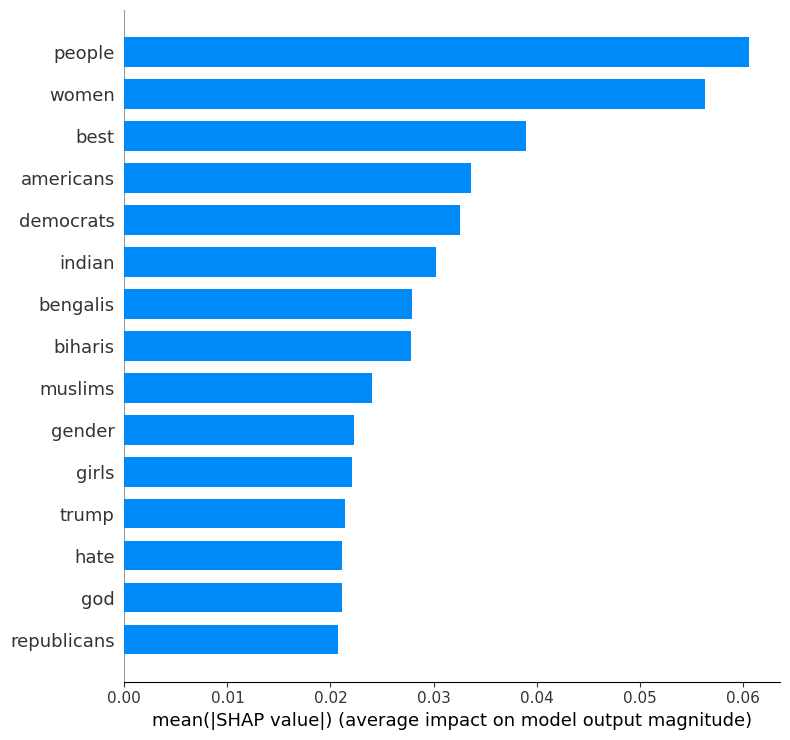

In [ ]:
# Get feature importance from logistic regression coefficients
feature_importances = np.abs(logistic_reg_model.coef_[0])
top_feature_indices = np.argsort(feature_importances)[-1000:]  # Keep top 1000 features

# 2. Create a smaller background dataset
np.random.seed(42)
n_background = 1000
background_indices = np.random.choice(train_vc.shape[0], n_background, replace=False)
background_data = train_vc[background_indices, :]

# 3. Create explainer with reduced background data
explainer = shap.LinearExplainer(
    logistic_reg_model,
    background_data
)

# 4. Calculate SHAP values for a subset of validation data
n_explain = 1000
val_indices = np.random.choice(val_vc.shape[0], n_explain, replace=False)
val_sample = val_vc[val_indices, :]

# 5. Get SHAP values only for top features
shap_values = explainer.shap_values(val_sample)

# 6. Get feature names for visualization
feature_names = np.array(tfidf_vc.get_feature_names_out())[top_feature_indices]

# 7. Create summary plot with reduced data
shap.summary_plot(
    shap_values[:, top_feature_indices],
    val_sample[:, top_feature_indices],
    feature_names=feature_names,
    plot_type='bar',
    max_display=15  # Show top 15 features
)

# **Preprocessing for LSTM, BiLSTM, GRU, Bidirectional GRU**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters for tokenization and padding
max_sequence_length = 100
vocab_size = 5000

# Tokenize the text data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_df["question_text"])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_df["question_text"])
val_sequences = tokenizer.texts_to_sequences(val_df["question_text"])

# Pad sequences to ensure uniform input size
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)
val_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length)

# Extract labels
train_labels = train_df["target"].values
val_labels = val_df["target"].values


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights for binary classification
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

print(f"Class Weights: {class_weights}")


Class Weights: {0: 0.5329540343699448, 1: 8.086324551145353}


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
def weighted_bce(class_weights):
    def loss_fn(y_true, y_pred):
        # Calculate weights for each sample
        weights = tf.cast(tf.where(tf.equal(y_true, 1), class_weights[1], class_weights[0]), dtype=tf.float32)
        # Calculate binary cross-entropy
        bce = K.binary_crossentropy(y_true, y_pred)
        # Apply weights to the loss
        return K.mean(weights * bce)
    return loss_fn


# **LSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Build the LSTM model without dropout
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with the custom weighted BCE loss
lstm_model.compile(optimizer=Adam(learning_rate=0.001),
              loss=weighted_bce(class_weights),
              metrics=['accuracy'])



In [ ]:
# Train LSTM
history = lstm_model.fit(
    train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=3,  # Adjust based on your needs
    batch_size=32,  # Adjust batch size
    verbose=1
)


Epoch 1/3
36735/36735 ━━━━━━━━━━━━━━━━━━━━ 383s 10ms/step - accuracy: 0.8607 - loss: 0.3400 - val_accuracy: 0.8690 - val_loss: 0.2923
Epoch 2/3
36735/36735 ━━━━━━━━━━━━━━━━━━━━ 287s 8ms/step - accuracy: 0.8801 - loss: 0.2841 - val_accuracy: 0.8648 - val_loss: 0.2887
Epoch 3/3
36735/36735 ━━━━━━━━━━━━━━━━━━━━ 322s 8ms/step - accuracy: 0.8855 - loss: 0.2732 - val_accuracy: 0.9031 - val_loss: 0.3049


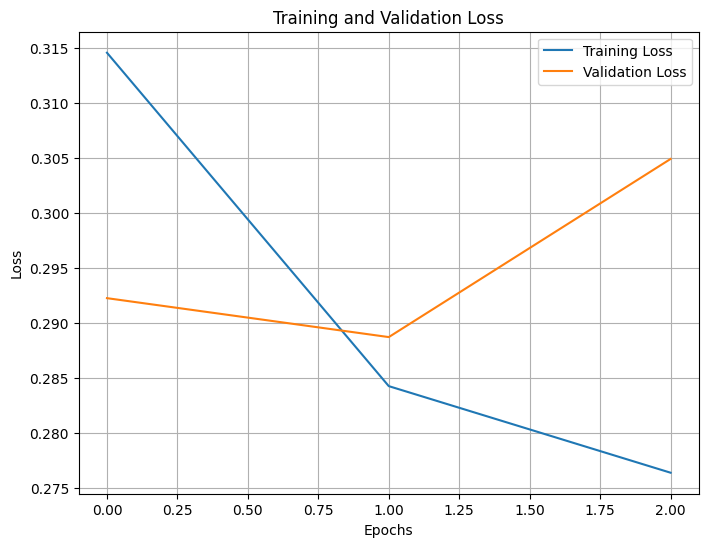

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 6))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# Predict on the validation set
val_predictions = (lstm_model.predict(val_sequences) > 0.5).astype("int32")

# Calculate accuracy
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions))

4082/4082 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
Validation Accuracy: 0.9031

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95    122488
           1       0.38      0.85      0.52      8125

    accuracy                           0.90    130613
   macro avg       0.68      0.88      0.73    130613
weighted avg       0.95      0.90      0.92    130613



# SHAP(LSTM)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

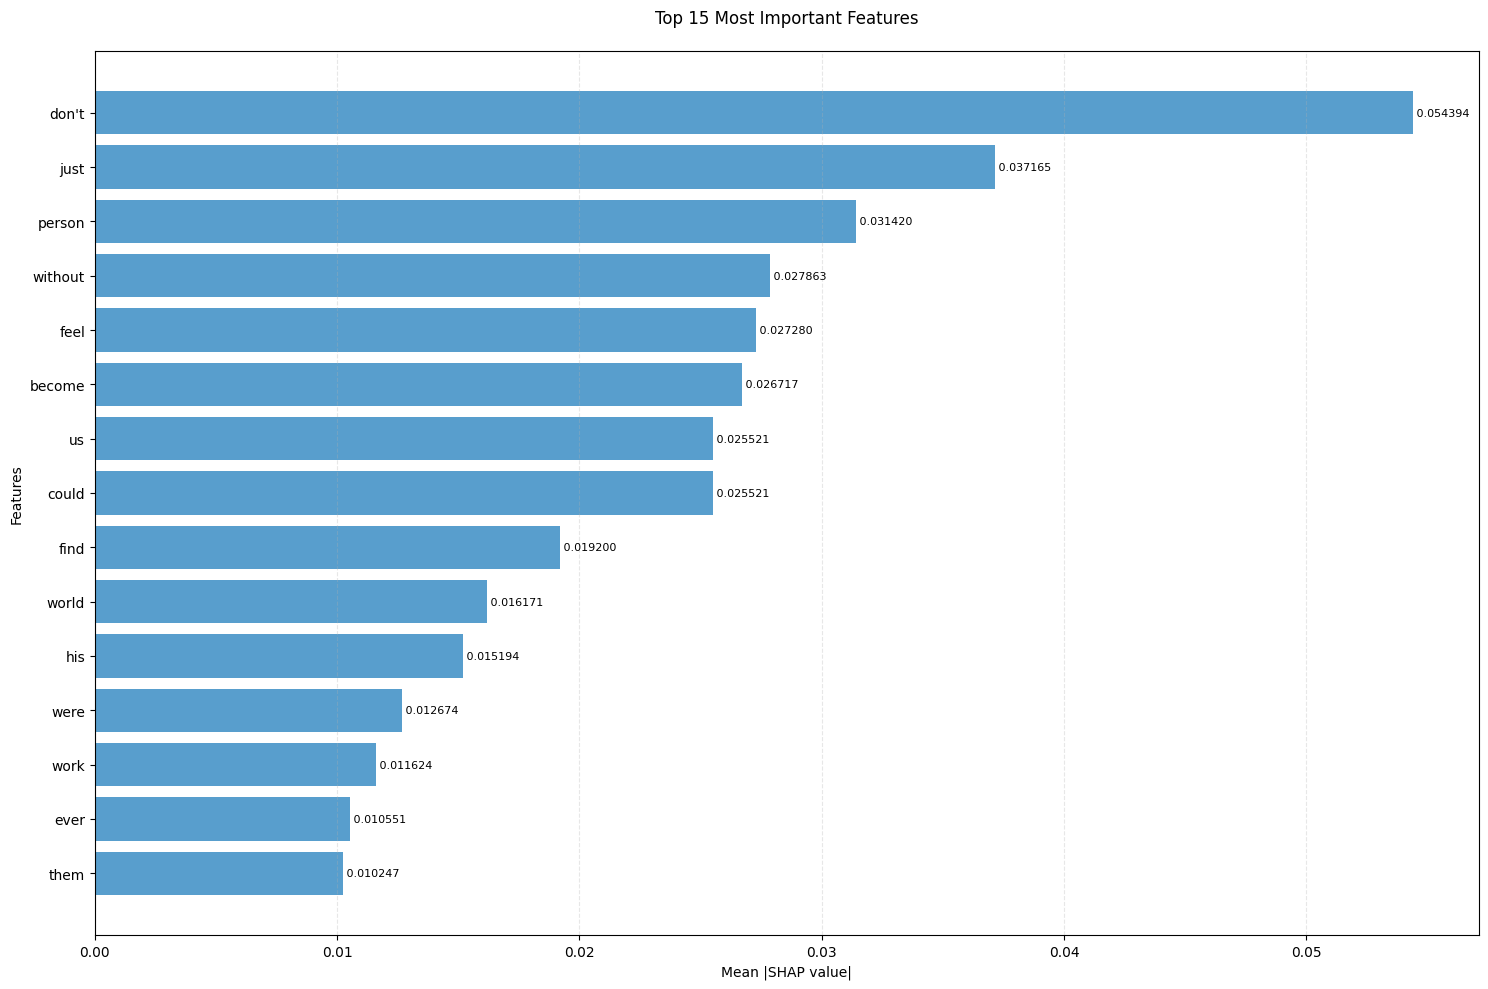


Top 15 Most Important Features:
    feature  importance
99    don't    0.054394
94     just    0.037165
97   person    0.031420
95  without    0.027863
98     feel    0.027280
92   become    0.026717
91       us    0.025521
96    could    0.025521
90     find    0.019200
93    world    0.016171
89      his    0.015194
87     were    0.012674
83     work    0.011624
88     ever    0.010551
86     them    0.010247


In [ ]:
# 1. Sample selection
n_background = 500
n_explain = 50
background_indices = np.random.choice(train_sequences.shape[0], n_background, replace=False)
val_indices = np.random.choice(val_sequences.shape[0], n_explain, replace=False)
background_data = train_sequences[background_indices]
val_sample = val_sequences[val_indices]

# 2. Create and run explainer
explainer = shap.KernelExplainer(
    model=lambda x: lstm_model.predict(x),
    data=background_data,
    nsamples=100
)

shap_values = explainer.shap_values(
    val_sample,
    nsamples=100,
    l1_reg="num_features(20)"
)

# 3. Create feature names mapping
feature_names = np.array([
    tokenizer.index_word.get(i+1, f'token_{i+1}')
    for i in range(max_sequence_length)
])

# 4. Calculate mean SHAP values and create DataFrame
mean_shap_values = np.abs(shap_values[0] if isinstance(shap_values, list) else shap_values).mean(0)
feature_importance = pd.DataFrame({
    'feature': feature_names.flatten(),
    'importance': mean_shap_values.flatten()
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
top_15 = feature_importance.head(15)

# 5. Create visualizations
plt.figure(figsize=(15, 10))

plt.title('SHAP Summary Plot', pad=20)



y_pos = np.arange(len(top_15))
plt.barh(y_pos, top_15['importance'], align='center', color='#2E86C1', alpha=0.8)
plt.yticks(y_pos, top_15['feature'])
plt.xlabel('Mean |SHAP value|')
plt.ylabel('Features')
plt.title('Top 15 Most Important Features', pad=20)

# Add value labels
for i, v in enumerate(top_15['importance']):
    plt.text(v, i, f' {v:.6f}', va='center', fontsize=8)

# Add grid and invert y-axis
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.gca().invert_yaxis()

# Adjust layout
plt.tight_layout(w_pad=4)
plt.show()

# Print numerical values
print("\nTop 15 Most Important Features:")
print(top_15.to_string(float_format=lambda x: '{:.6f}'.format(x)))


# **Bidirectional LSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,Bidirectional
from tensorflow.keras.optimizers import Adam

# Build the LSTM model without dropout
bilstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with the custom weighted BCE loss
bilstm_model.compile(optimizer=Adam(learning_rate=0.001),
              loss=weighted_bce(class_weights),
              metrics=['accuracy'])



In [ ]:
history = bilstm_model.fit(
    train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=3,  # Adjust based on your needs
    batch_size=32,  # Adjust batch size
    verbose=1
)


Epoch 1/3
36735/36735 ━━━━━━━━━━━━━━━━━━━━ 439s 12ms/step - accuracy: 0.8569 - loss: 0.3399 - val_accuracy: 0.8827 - val_loss: 0.2899
Epoch 2/3
36735/36735 ━━━━━━━━━━━━━━━━━━━━ 445s 12ms/step - accuracy: 0.8824 - loss: 0.2817 - val_accuracy: 0.8932 - val_loss: 0.2937
Epoch 3/3
36735/36735 ━━━━━━━━━━━━━━━━━━━━ 439s 12ms/step - accuracy: 0.8842 - loss: 0.2718 - val_accuracy: 0.8847 - val_loss: 0.2905


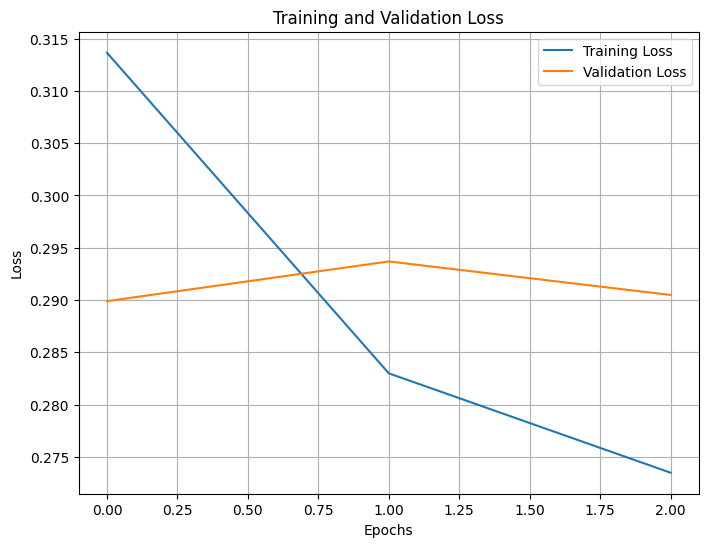

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8, 6))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# Predict on the validation set
val_predictions = (bilstm_model.predict(val_sequences) > 0.5).astype("int32")

# Calculate accuracy
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions))

4082/4082 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step
Validation Accuracy: 0.8847

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.94    122488
           1       0.34      0.89      0.49      8125

    accuracy                           0.88    130613
   macro avg       0.66      0.89      0.71    130613
weighted avg       0.95      0.88      0.91    130613



# SHAP(BiLSTM)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

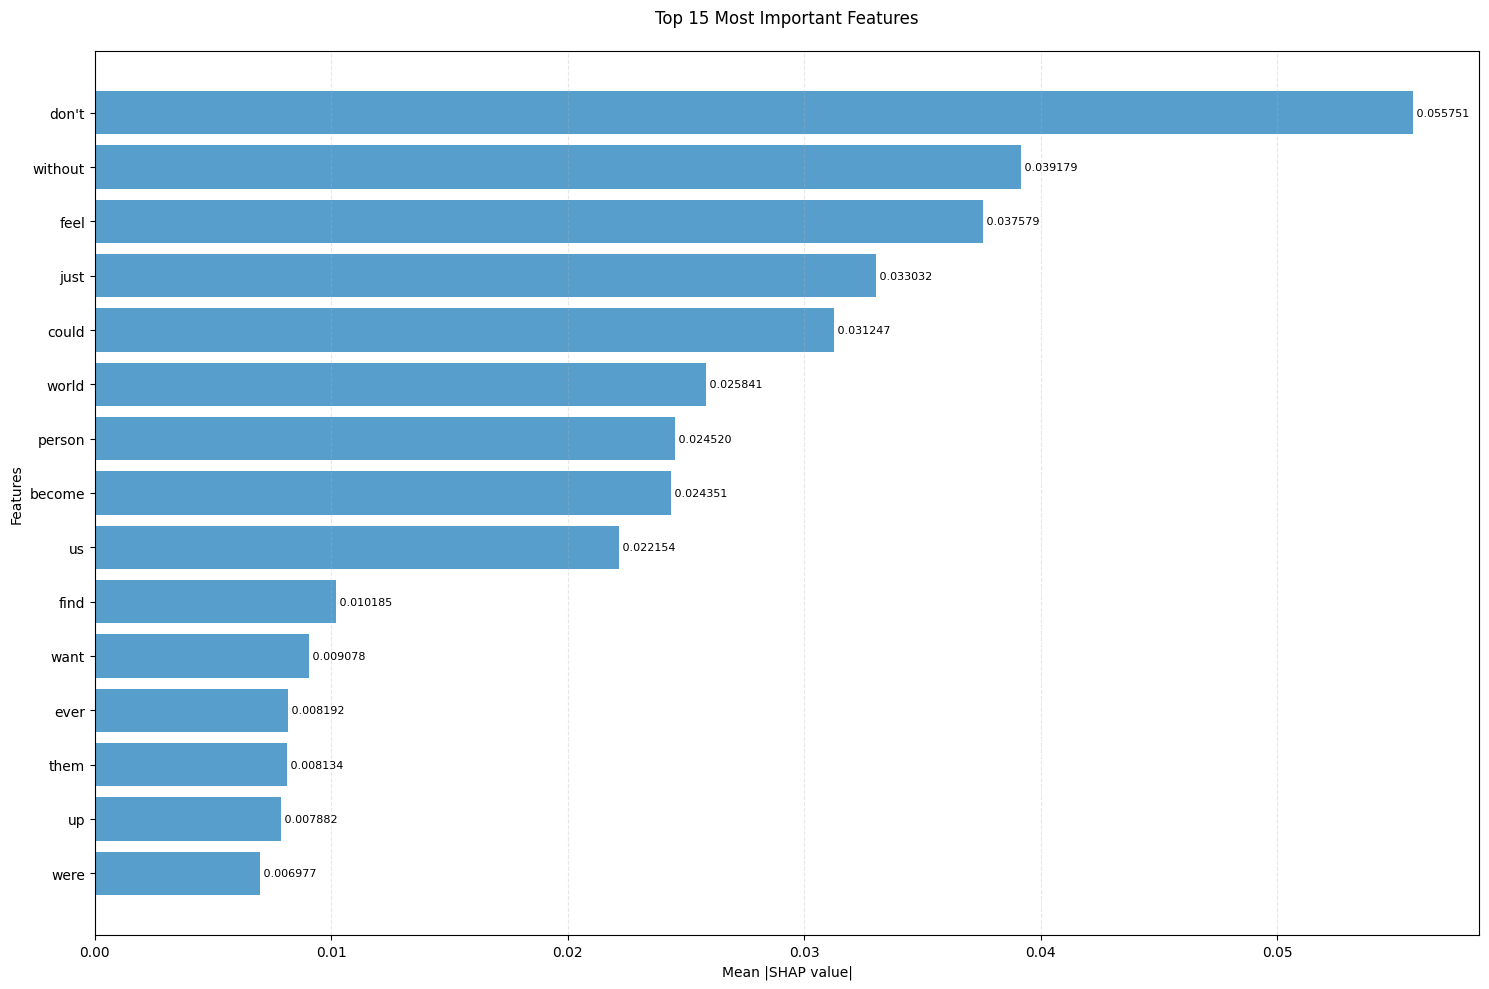


Top 15 Most Important Features:
    feature  importance
99    don't    0.055751
95  without    0.039179
98     feel    0.037579
94     just    0.033032
96    could    0.031247
93    world    0.025841
97   person    0.024520
92   become    0.024351
91       us    0.022154
90     find    0.010185
84     want    0.009078
88     ever    0.008192
86     them    0.008134
81       up    0.007882
87     were    0.006977


In [ ]:
# 1. Sample selection
n_background = 500
n_explain = 50
background_indices = np.random.choice(train_sequences.shape[0], n_background, replace=False)
val_indices = np.random.choice(val_sequences.shape[0], n_explain, replace=False)
background_data = train_sequences[background_indices]
val_sample = val_sequences[val_indices]

# 2. Create and run explainer
explainer = shap.KernelExplainer(
    model=lambda x: bilstm_model.predict(x),
    data=background_data,
    nsamples=100
)

shap_values = explainer.shap_values(
    val_sample,
    nsamples=100,
    l1_reg="num_features(20)"
)

# 3. Create feature names mapping
feature_names = np.array([
    tokenizer.index_word.get(i+1, f'token_{i+1}')
    for i in range(max_sequence_length)
])

# 4. Calculate mean SHAP values and create DataFrame
mean_shap_values = np.abs(shap_values[0] if isinstance(shap_values, list) else shap_values).mean(0)
feature_importance = pd.DataFrame({
    'feature': feature_names.flatten(),
    'importance': mean_shap_values.flatten()
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
top_15 = feature_importance.head(15)

# 5. Create visualizations
plt.figure(figsize=(15, 10))

plt.title('SHAP Summary Plot', pad=20)



y_pos = np.arange(len(top_15))
plt.barh(y_pos, top_15['importance'], align='center', color='#2E86C1', alpha=0.8)
plt.yticks(y_pos, top_15['feature'])
plt.xlabel('Mean |SHAP value|')
plt.ylabel('Features')
plt.title('Top 15 Most Important Features', pad=20)

# Add value labels
for i, v in enumerate(top_15['importance']):
    plt.text(v, i, f' {v:.6f}', va='center', fontsize=8)

# Add grid and invert y-axis
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.gca().invert_yaxis()

# Adjust layout
plt.tight_layout(w_pad=4)
plt.show()

# Print numerical values
print("\nTop 15 Most Important Features:")
print(top_15.to_string(float_format=lambda x: '{:.6f}'.format(x)))


# **GRU**

Epoch 1/3
36735/36735 ━━━━━━━━━━━━━━━━━━━━ 284s 8ms/step - accuracy: 0.8556 - loss: 0.3382 - val_accuracy: 0.8651 - val_loss: 0.2949
Epoch 2/3
36735/36735 ━━━━━━━━━━━━━━━━━━━━ 322s 8ms/step - accuracy: 0.8806 - loss: 0.2832 - val_accuracy: 0.8856 - val_loss: 0.2895
Epoch 3/3
36735/36735 ━━━━━━━━━━━━━━━━━━━━ 321s 8ms/step - accuracy: 0.8855 - loss: 0.2744 - val_accuracy: 0.8429 - val_loss: 0.2979


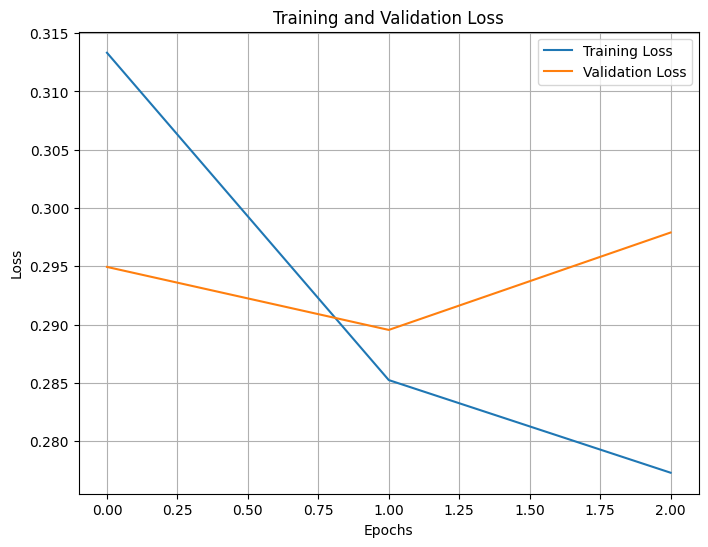

NameError: name 'model' is not defined

In [ ]:


from tensorflow.keras.layers import GRU, Bidirectional
# Build the GRU model
gru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),
    GRU(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the gru_model
gru_model.compile(optimizer=Adam(learning_rate=0.001),
              loss=weighted_bce(class_weights),
              metrics=['accuracy'])

history = gru_model.fit(
    train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=3,
    batch_size=32,
    verbose=1
)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()






In [ ]:
# Predict on the validation set
val_predictions = (gru_model.predict(val_sequences) > 0.5).astype("int32")

# Calculate accuracy
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions))

4082/4082 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
Validation Accuracy: 0.8429

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91    122488
           1       0.27      0.92      0.42      8125

    accuracy                           0.84    130613
   macro avg       0.63      0.88      0.67    130613
weighted avg       0.95      0.84      0.88    130613



# SHAP(GRU)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

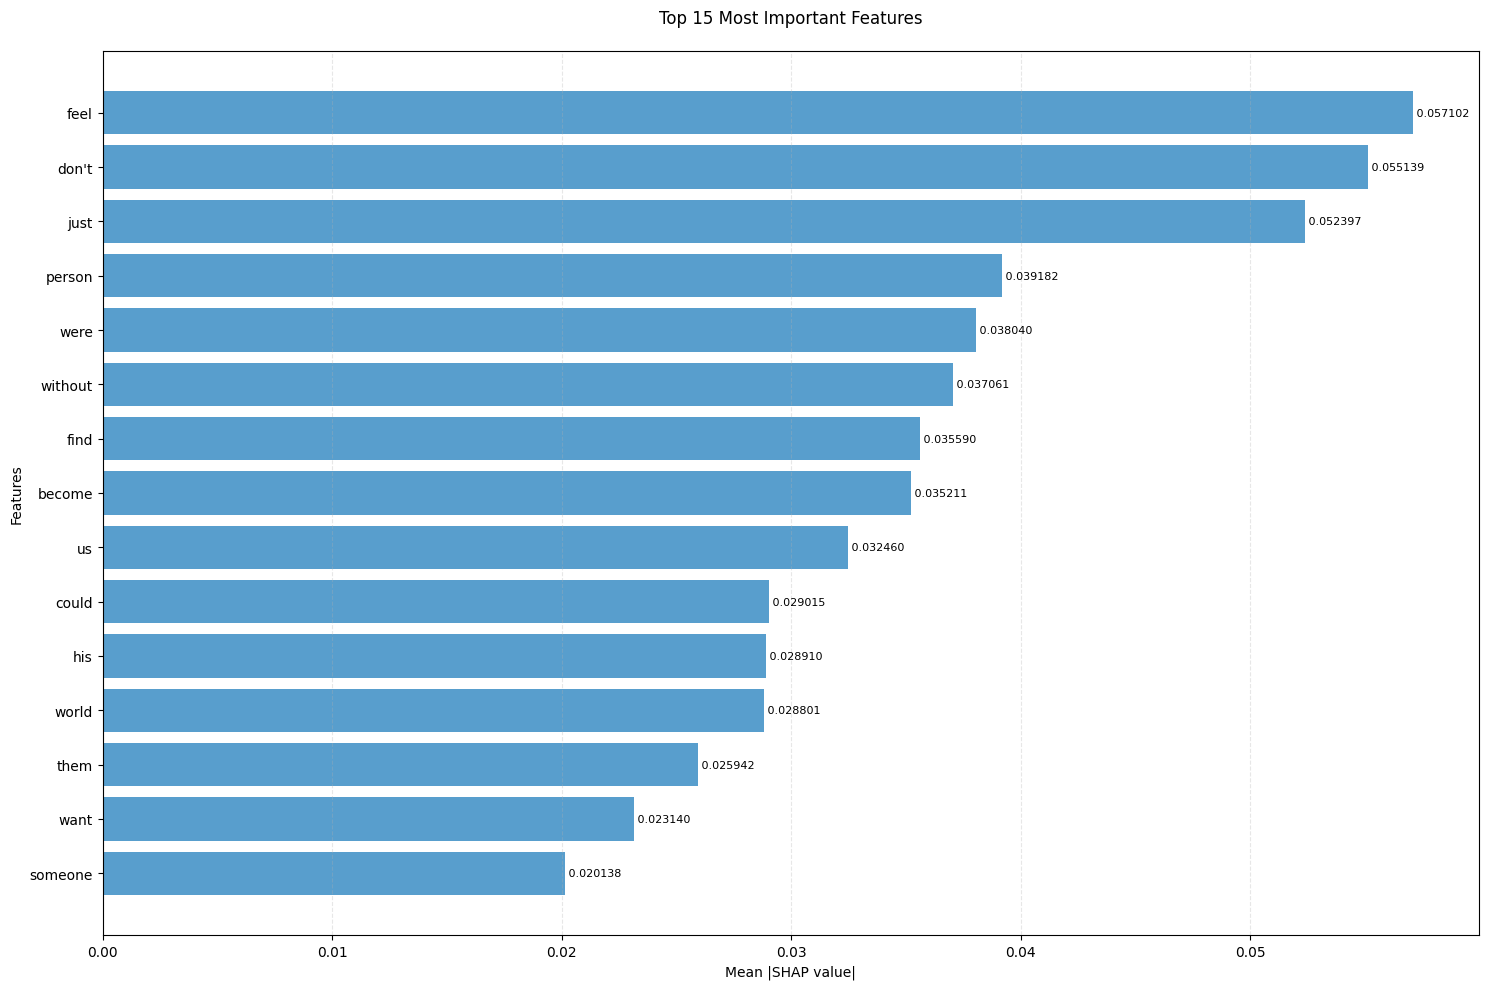


Top 15 Most Important Features:
    feature  importance
98     feel    0.057102
99    don't    0.055139
94     just    0.052397
97   person    0.039182
87     were    0.038040
95  without    0.037061
90     find    0.035590
92   become    0.035211
91       us    0.032460
96    could    0.029015
89      his    0.028910
93    world    0.028801
86     them    0.025942
84     want    0.023140
74  someone    0.020138


In [ ]:
# 1. Sample selection
n_background = 500
n_explain = 50
background_indices = np.random.choice(train_sequences.shape[0], n_background, replace=False)
val_indices = np.random.choice(val_sequences.shape[0], n_explain, replace=False)
background_data = train_sequences[background_indices]
val_sample = val_sequences[val_indices]

# 2. Create and run explainer
explainer = shap.KernelExplainer(
    model=lambda x: gru_model.predict(x),
    data=background_data,
    nsamples=100
)

shap_values = explainer.shap_values(
    val_sample,
    nsamples=100,
    l1_reg="num_features(20)"
)

# 3. Create feature names mapping
feature_names = np.array([
    tokenizer.index_word.get(i+1, f'token_{i+1}')
    for i in range(max_sequence_length)
])

# 4. Calculate mean SHAP values and create DataFrame
mean_shap_values = np.abs(shap_values[0] if isinstance(shap_values, list) else shap_values).mean(0)
feature_importance = pd.DataFrame({
    'feature': feature_names.flatten(),
    'importance': mean_shap_values.flatten()
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
top_15 = feature_importance.head(15)

# 5. Create visualizations
plt.figure(figsize=(15, 10))

plt.title('SHAP Summary Plot', pad=20)



y_pos = np.arange(len(top_15))
plt.barh(y_pos, top_15['importance'], align='center', color='#2E86C1', alpha=0.8)
plt.yticks(y_pos, top_15['feature'])
plt.xlabel('Mean |SHAP value|')
plt.ylabel('Features')
plt.title('Top 15 Most Important Features', pad=20)

# Add value labels
for i, v in enumerate(top_15['importance']):
    plt.text(v, i, f' {v:.6f}', va='center', fontsize=8)

# Add grid and invert y-axis
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.gca().invert_yaxis()

# Adjust layout
plt.tight_layout(w_pad=4)
plt.show()

# Print numerical values
print("\nTop 15 Most Important Features:")
print(top_15.to_string(float_format=lambda x: '{:.6f}'.format(x)))


### **Bidirectional GRU**

Epoch 1/3
36735/36735 ━━━━━━━━━━━━━━━━━━━━ 427s 12ms/step - accuracy: 0.8537 - loss: 0.3394 - val_accuracy: 0.8901 - val_loss: 0.2968
Epoch 2/3
36735/36735 ━━━━━━━━━━━━━━━━━━━━ 439s 11ms/step - accuracy: 0.8809 - loss: 0.2865 - val_accuracy: 0.8853 - val_loss: 0.2915
Epoch 3/3
36735/36735 ━━━━━━━━━━━━━━━━━━━━ 444s 12ms/step - accuracy: 0.8828 - loss: 0.2732 - val_accuracy: 0.8746 - val_loss: 0.2886


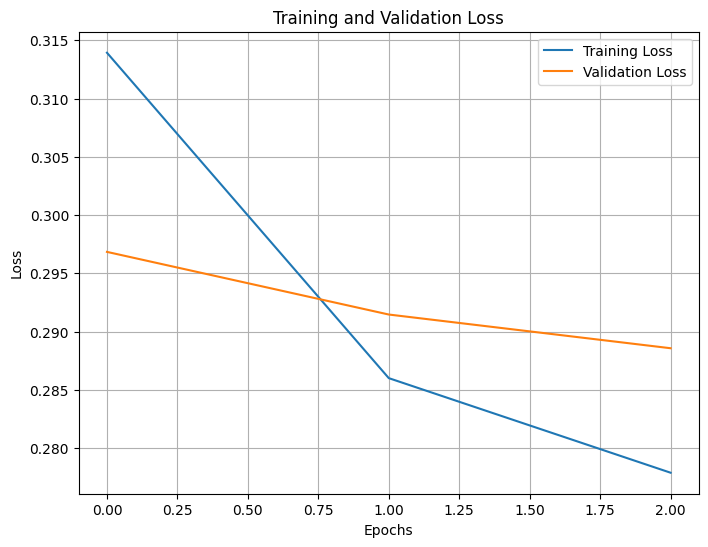

In [ ]:
# Bidirectional GRU
# Build the Bidirectional GRU model
bigru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),
    Bidirectional(GRU(64, return_sequences=False)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the bigru_model
bigru_model.compile(optimizer=Adam(learning_rate=0.001),
              loss=weighted_bce(class_weights),
              metrics=['accuracy'])

history = bigru_model.fit(
    train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=3,
    batch_size=32,
    verbose=1
)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Predict on the validation set
val_predictions = (bigru_model.predict(val_sequences) > 0.5).astype("int32")

# Calculate accuracy
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions))

4082/4082 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step
Validation Accuracy: 0.8746

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93    122488
           1       0.32      0.90      0.47      8125

    accuracy                           0.87    130613
   macro avg       0.66      0.88      0.70    130613
weighted avg       0.95      0.87      0.90    130613



# SHAP(BiGRU)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

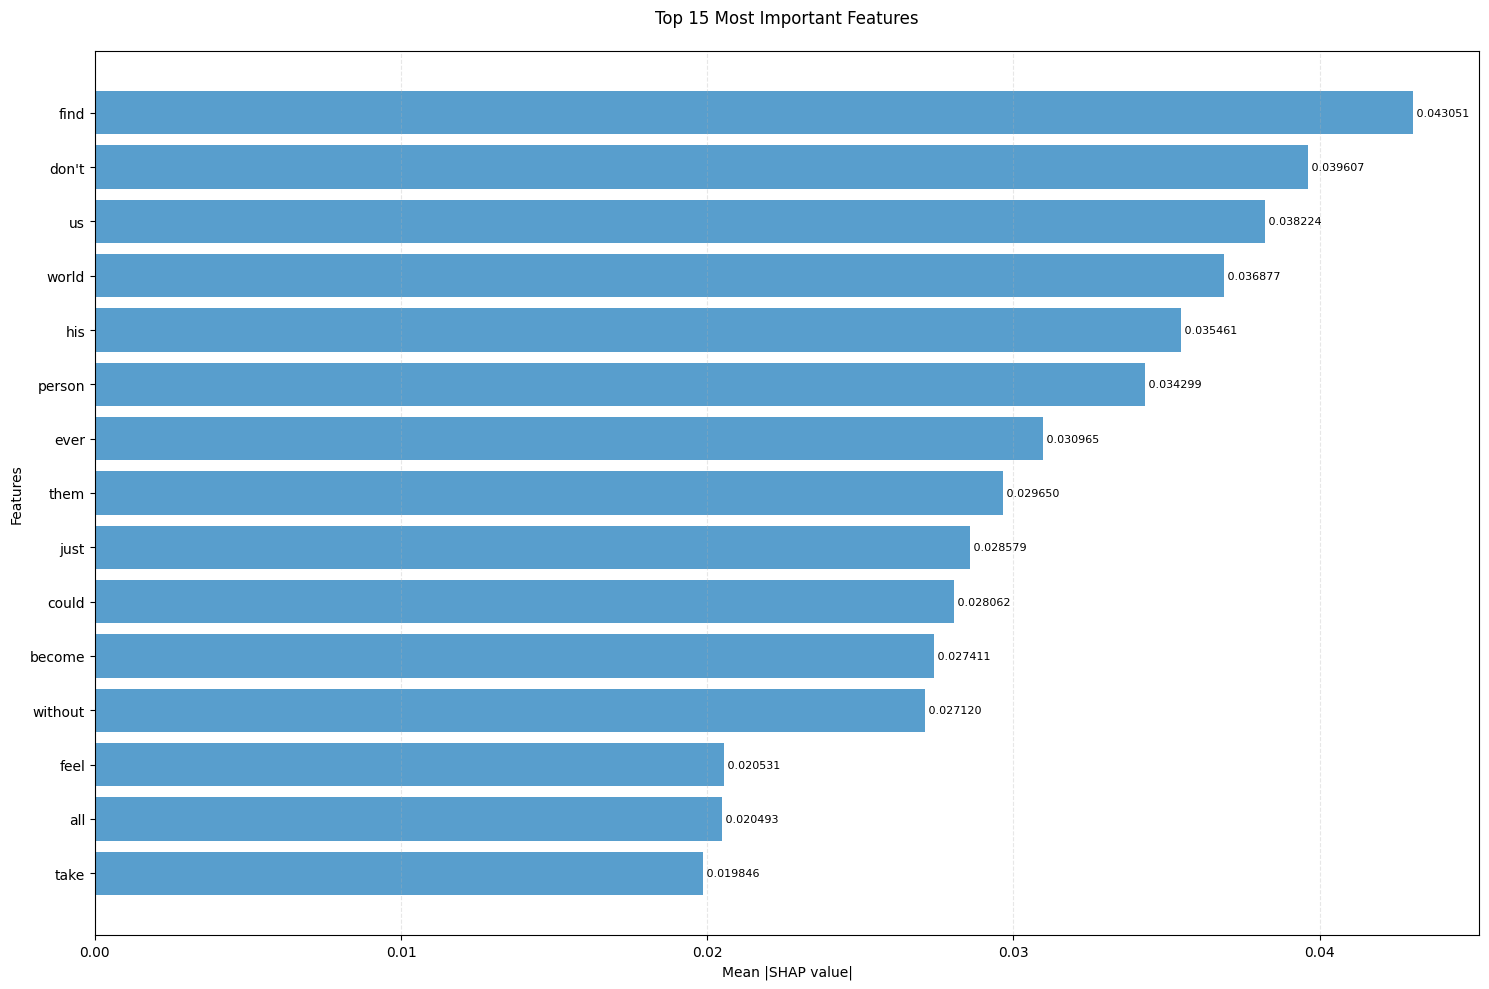


Top 15 Most Important Features:
    feature  importance
90     find    0.043051
99    don't    0.039607
91       us    0.038224
93    world    0.036877
89      his    0.035461
97   person    0.034299
88     ever    0.030965
86     them    0.029650
94     just    0.028579
96    could    0.028062
92   become    0.027411
95  without    0.027120
98     feel    0.020531
65      all    0.020493
85     take    0.019846


In [ ]:
# 1. Sample selection
n_background = 500
n_explain = 50
background_indices = np.random.choice(train_sequences.shape[0], n_background, replace=False)
val_indices = np.random.choice(val_sequences.shape[0], n_explain, replace=False)
background_data = train_sequences[background_indices]
val_sample = val_sequences[val_indices]

# 2. Create and run explainer
explainer = shap.KernelExplainer(
    model=lambda x: bigru_model.predict(x),
    data=background_data,
    nsamples=100
)

shap_values = explainer.shap_values(
    val_sample,
    nsamples=100,
    l1_reg="num_features(20)"
)

# 3. Create feature names mapping
feature_names = np.array([
    tokenizer.index_word.get(i+1, f'token_{i+1}')
    for i in range(max_sequence_length)
])

# 4. Calculate mean SHAP values and create DataFrame
mean_shap_values = np.abs(shap_values[0] if isinstance(shap_values, list) else shap_values).mean(0)
feature_importance = pd.DataFrame({
    'feature': feature_names.flatten(),
    'importance': mean_shap_values.flatten()
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
top_15 = feature_importance.head(15)

# 5. Create visualizations
plt.figure(figsize=(15, 10))

plt.title('SHAP Summary Plot', pad=20)



y_pos = np.arange(len(top_15))
plt.barh(y_pos, top_15['importance'], align='center', color='#2E86C1', alpha=0.8)
plt.yticks(y_pos, top_15['feature'])
plt.xlabel('Mean |SHAP value|')
plt.ylabel('Features')
plt.title('Top 15 Most Important Features', pad=20)

# Add value labels
for i, v in enumerate(top_15['importance']):
    plt.text(v, i, f' {v:.6f}', va='center', fontsize=8)

# Add grid and invert y-axis
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.gca().invert_yaxis()

# Adjust layout
plt.tight_layout(w_pad=4)
plt.show()

# Print numerical values
print("\nTop 15 Most Important Features:")
print(top_15.to_string(float_format=lambda x: '{:.6f}'.format(x)))
